<a href="https://colab.research.google.com/github/nhjeong/BiS800/blob/master/Task1_Official_Diceloss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Importing libraries**

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPool2D, UpSampling2D, Concatenate
from keras.optimizers import Adam
from keras import backend as K
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## **2. Loading data**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!cp -r /content/gdrive/'My Drive'/'Colab Notebooks'/Heart data
!ls data

Mounted at /content/gdrive
dataset.json  Heart  imagesTr  imagesTs  labelsTr  model


In [0]:
img_path = 'data/imagesTr'
label_path = 'data/labelsTr'

tr_data = [3, 4, 5, 7, 9, 10, 11, 14, 16, 17, 18, 19, 20, 21, 22, 23]
ts_data = [24, 26, 29, 30]


# Dataset for training and validation
X_train = []
Y_train = []
for i in range(np.size(tr_data)):
  img_filename = os.path.join(img_path, 'la_'+'{:03}'.format(tr_data[i])+'.nii.gz')
  label_filename = os.path.join(label_path, 'la_'+'{:03}'.format(tr_data[i])+'.nii.gz')
  img = nib.load(img_filename)
  label = nib.load(label_filename)
  #print(np.min(img.get_data()))  
  #print(np.max(img.get_data()))
  X_train.append(img.get_data()/np.max(img.get_data()))              # fitGenerator. 
  Y_train.append(label.get_data())
  
X1 = X_train[0]
Y1 = Y_train[0]
for i in range(np.size(tr_data)-1):
  X1 = np.concatenate((X1, X_train[i+1]), axis=2)
  Y1 = np.concatenate((Y1, Y_train[i+1]), axis=2)
  
X1 = np.expand_dims(np.transpose(X1, (2, 0, 1)), axis=3)
Y1 = np.expand_dims(np.transpose(Y1, (2, 0, 1)), axis=3)

Y1_onehot = np.ones_like(Y1)
Y1_onehot = np.concatenate((Y1_onehot, Y1), axis=3)
Y1_onehot[:,:,:,0] = Y1_onehot[:,:,:,0]-Y1_onehot[:,:,:,1]

X_tr, X_va, Y_tr, Y_va = train_test_split(X1, Y1_onehot, test_size=300/1812, shuffle = True)



# Dataset for test
X_test = []
Y_test = []
for i in range(np.size(ts_data)):
  img_filename = os.path.join(img_path, 'la_'+'{:03}'.format(ts_data[i])+'.nii.gz')
  label_filename = os.path.join(label_path, 'la_'+'{:03}'.format(ts_data[i])+'.nii.gz')
  img = nib.load(img_filename)
  label = nib.load(label_filename)
  #print(np.min(img.get_data()))  
  #print(np.max(img.get_data()))
  X_test.append(img.get_data()/np.max(img.get_data()))
  Y_test.append(label.get_data())
  
X2 = X_test[0]
Y2 = Y_test[0]
for i in range(np.size(ts_data)-1):
  X2 = np.concatenate((X2, X_test[i+1]), axis=2)
  Y2 = np.concatenate((Y2, Y_test[i+1]), axis=2)
  
X_ts = np.expand_dims(np.transpose(X2, (2, 0, 1)), axis=3)
Y3 = np.expand_dims(np.transpose(Y2, (2, 0, 1)), axis=3)

Y_ts = np.ones_like(Y3)
Y_ts = np.concatenate((Y_ts, Y3), axis=3)
Y_ts[:,:,:,0] = Y_ts[:,:,:,0]-Y_ts[:,:,:,1]

## **3. Defining functions for constructing my neural network**

In [0]:
# First let's define the two different types of layers that we will be using.

def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    
    residual = Conv2D(filters, (3, 3), padding='same')(conv1)
    residual = BatchNormalization()(residual)    
    residual = Activation('relu')(residual)    

    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual


def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding='same')(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    
    conv1 = Conv2D(filters, (3, 3), padding='same')(concat)
    conv1 = BatchNormalization()(conv1)   
    conv1 = Activation('relu')(conv1) 
    
    conv2 = Conv2D(filters, (3, 3), padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)  
    output = Activation('relu')(conv2) 
    
    return output
  
def dice_loss(y_true, y_pred, smooth=1e-6):
    intersection = 2 * K.sum(y_true * y_pred, axis=-1)
    dice = intersection / (K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) + smooth)
    
    return 1-dice
  

## **4. Modeling the neural network**

In [5]:
num = 1
resol = X1.shape[1]
minibatch_size = 12
    
    
# Make a custom U-nets implementation.
filters = 16
input_layer = Input(batch_shape = [minibatch_size, resol, resol, num])
layers = [input_layer]
residuals = []

# Down 1
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5
d5 = down(d4, filters, pool=False)

# Up 1
up1 = up(d5, residual=residuals[-1], filters=filters/2)

filters /= 2

# Up 2
up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

# Up 3
up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

# Up 4
up4 = up(up3, residual=residuals[-4], filters=filters/2)

fc1 = Conv2D(filters=32, kernel_size=(1, 1), activation="relu")(up4)
out = Conv2D(filters=num*2, kernel_size=(1, 1), activation="softmax")(fc1)

model = Model(input_layer, out)
model.summary() 

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (12, 320, 320, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (12, 320, 320, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (12, 320, 320, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (12, 320, 320, 16)   0           batch_normalization_1[0][0]      
_____________________________________

## **5. Training**

In [0]:

def display(net, X, slices):
  display_index = np.arange(100, 1100, 100)
  Y = net.predict(X)
  Y_map = np.argmax(Y, axis=3)
  
  #np.random.seed()
  #ind = np.random.permutation(range(X.shape[0]))
  
  plt.figure(figsize=(20, 4))
  for i in range(slices):
    plt.subplot(2, slices, i+1)
    plt.imshow(np.squeeze(X[display_index[i],]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.clim((0,1))
    plt.subplot(2, slices, i+1+slices)
    plt.imshow(Y_map[display_index[i],], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.clim((0,1))  
  plt.show()

Epoch #1
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 93s 61ms/step - loss: 0.2457 - val_loss: 0.1634


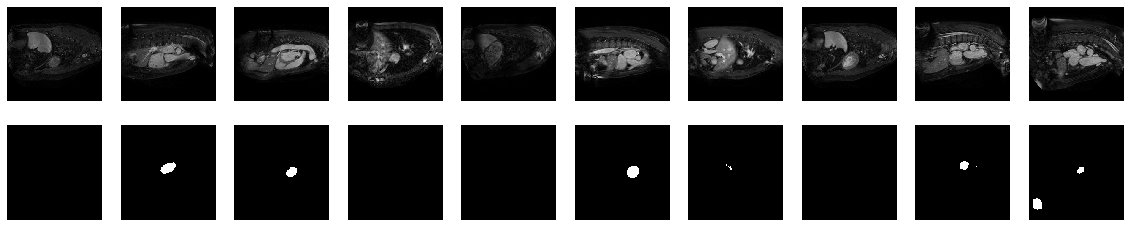

Epoch #2
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 83s 55ms/step - loss: 0.1087 - val_loss: 0.0882


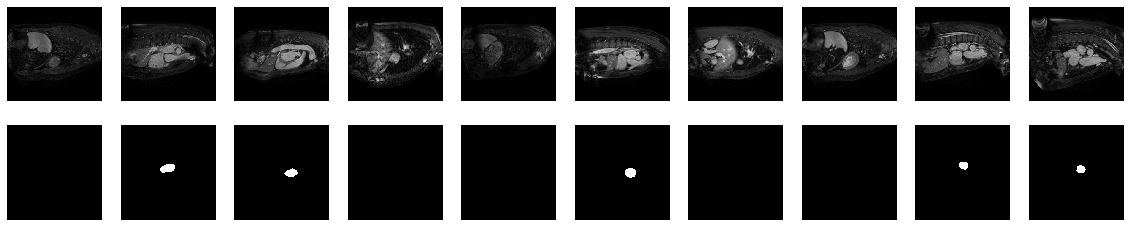

Epoch #3
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 82s 54ms/step - loss: 0.0631 - val_loss: 0.0512


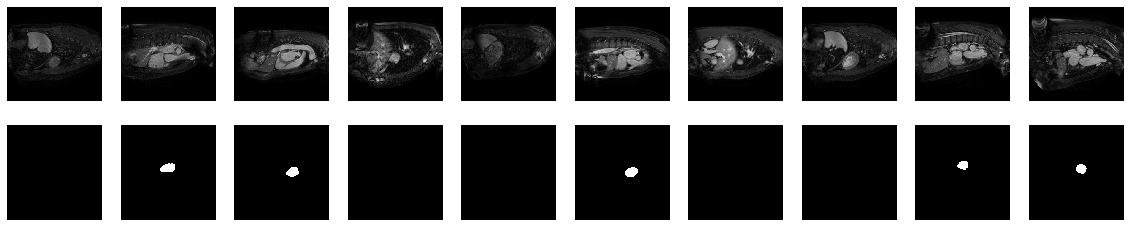

Epoch #4
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 82s 54ms/step - loss: 0.0403 - val_loss: 0.0348


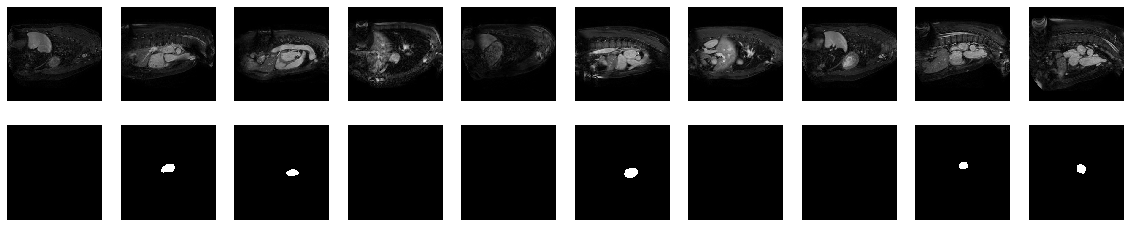

Epoch #5
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 82s 54ms/step - loss: 0.0268 - val_loss: 0.0233


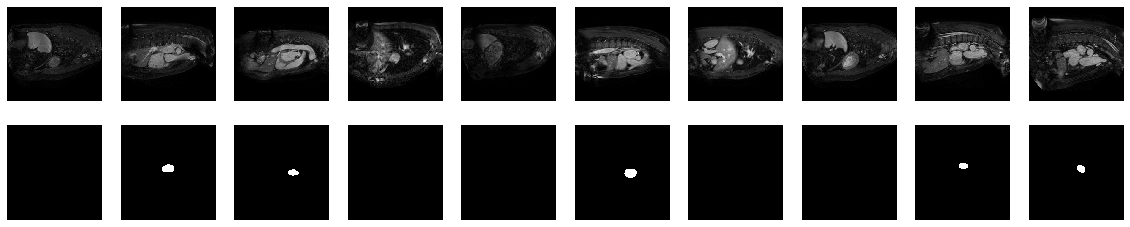

Epoch #6
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 83s 55ms/step - loss: 0.0186 - val_loss: 0.0171


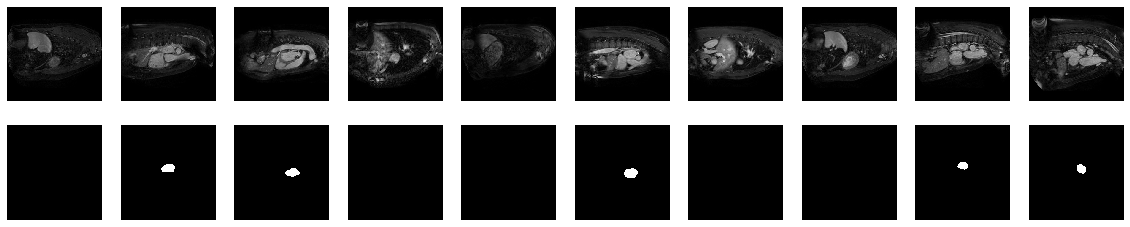

Epoch #7
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 54ms/step - loss: 0.0135 - val_loss: 0.0120


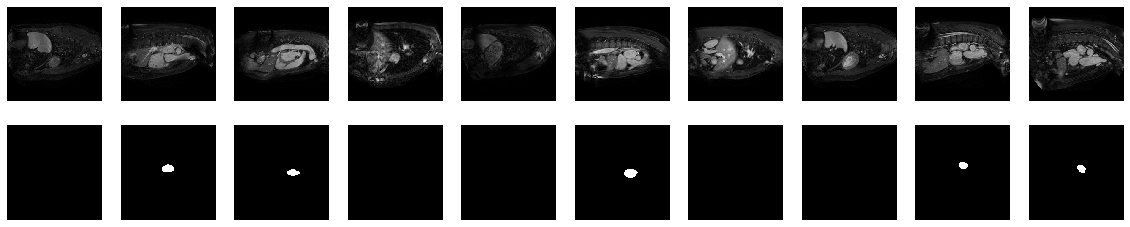

Epoch #8
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 82s 54ms/step - loss: 0.0102 - val_loss: 0.0094


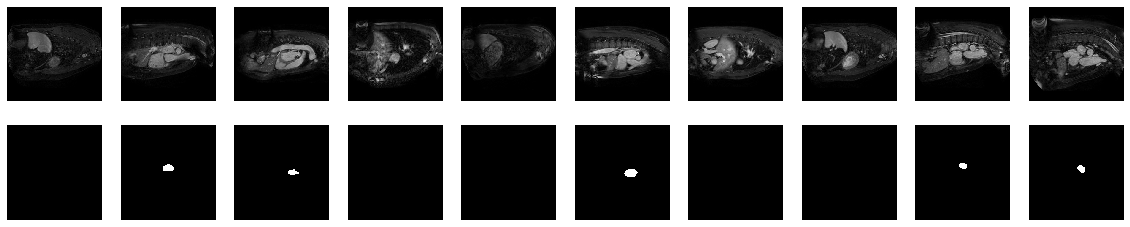

Epoch #9
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 54ms/step - loss: 0.0078 - val_loss: 0.0072


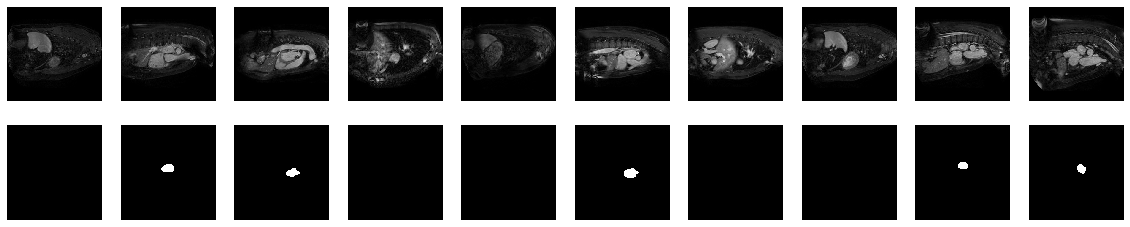

Epoch #10
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 82s 54ms/step - loss: 0.0062 - val_loss: 0.0058


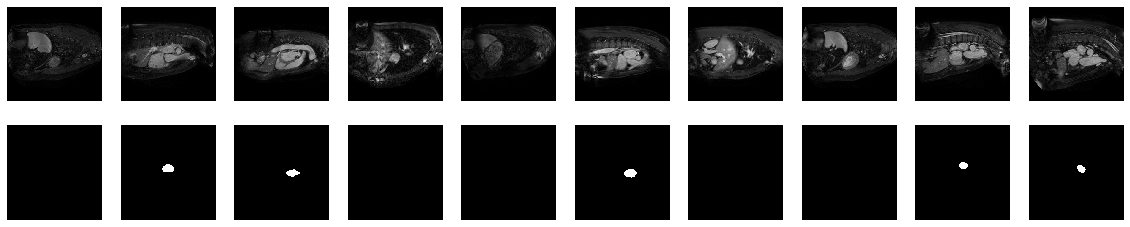

Epoch #11
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 80s 53ms/step - loss: 0.0050 - val_loss: 0.0047


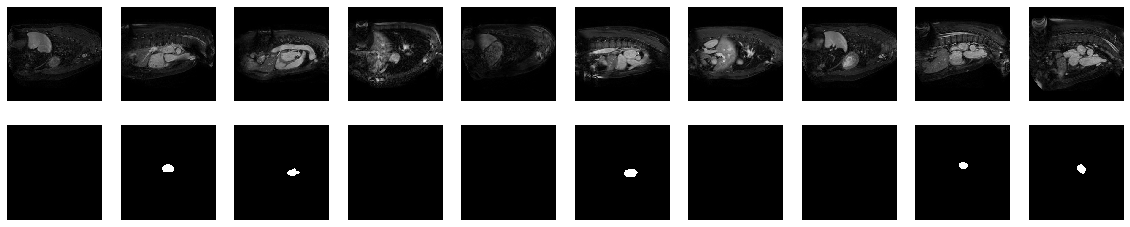

Epoch #12
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 53ms/step - loss: 0.0041 - val_loss: 0.0038


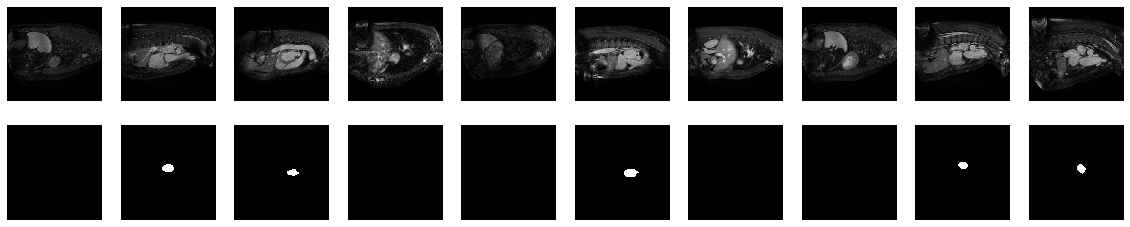

Epoch #13
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 53ms/step - loss: 0.0034 - val_loss: 0.0033


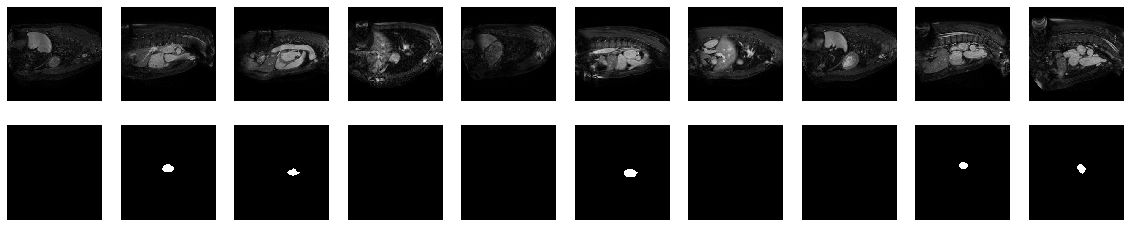

Epoch #14
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 54ms/step - loss: 0.0028 - val_loss: 0.0027


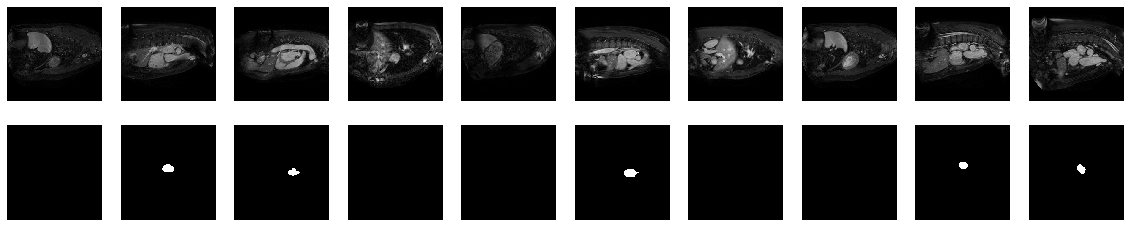

Epoch #15
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 53ms/step - loss: 0.0024 - val_loss: 0.0023


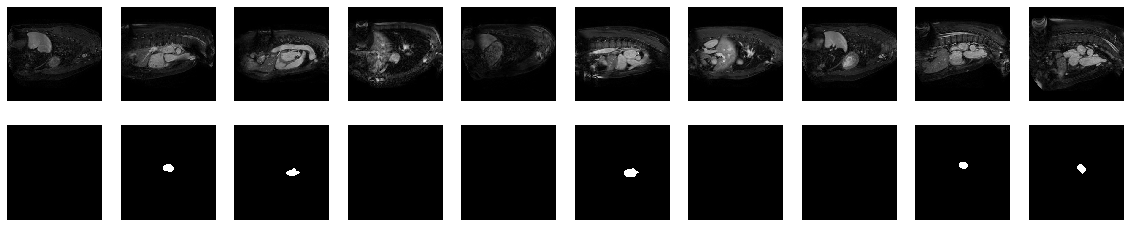

Epoch #16
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 82s 54ms/step - loss: 0.0020 - val_loss: 0.0020


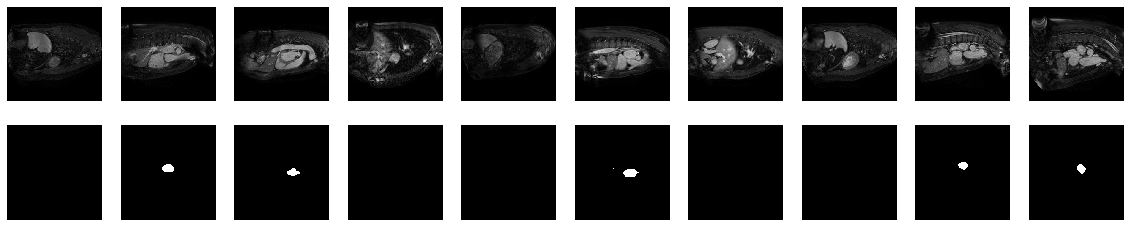

Epoch #17
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 54ms/step - loss: 0.0018 - val_loss: 0.0017


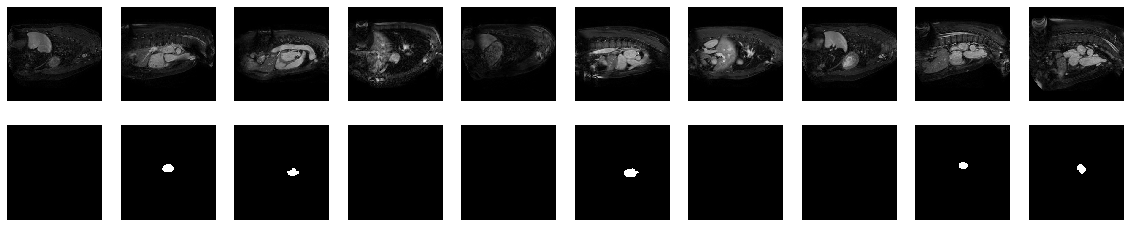

Epoch #18
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 54ms/step - loss: 0.0016 - val_loss: 0.0018


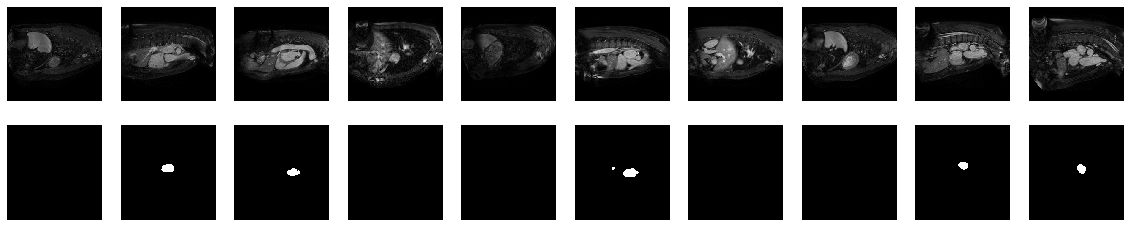

Epoch #19
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 54ms/step - loss: 0.0013 - val_loss: 0.0014


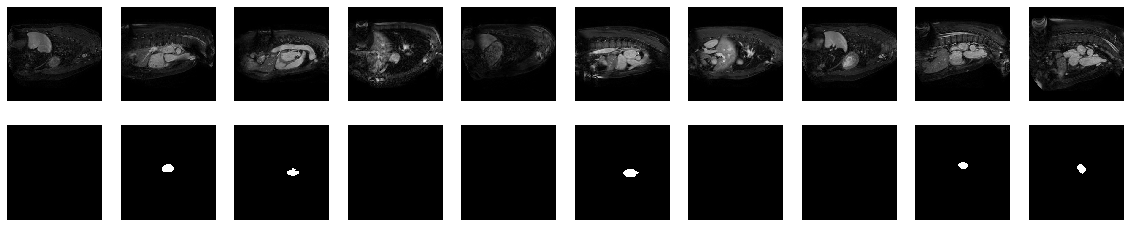

Epoch #20
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 82s 54ms/step - loss: 0.0012 - val_loss: 0.0013


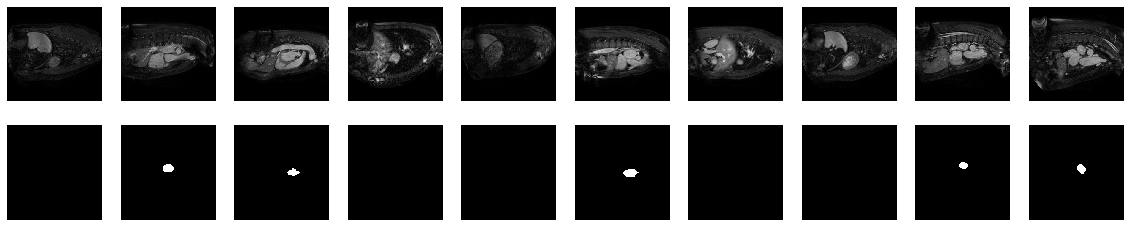

Epoch #21
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 54ms/step - loss: 0.0010 - val_loss: 0.0011


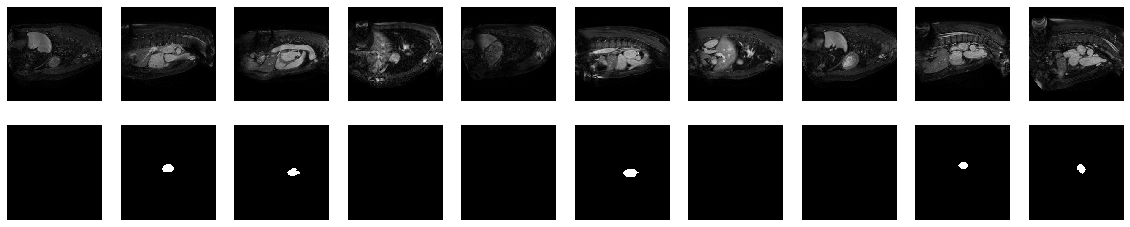

Epoch #22
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 82s 54ms/step - loss: 9.4055e-04 - val_loss: 0.0010


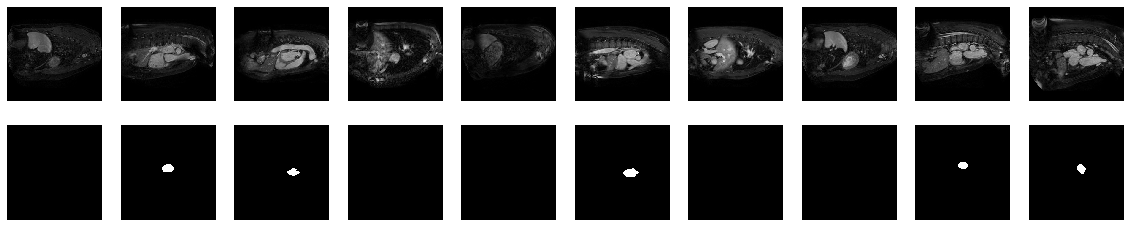

Epoch #23
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 54ms/step - loss: 8.5784e-04 - val_loss: 9.5447e-04


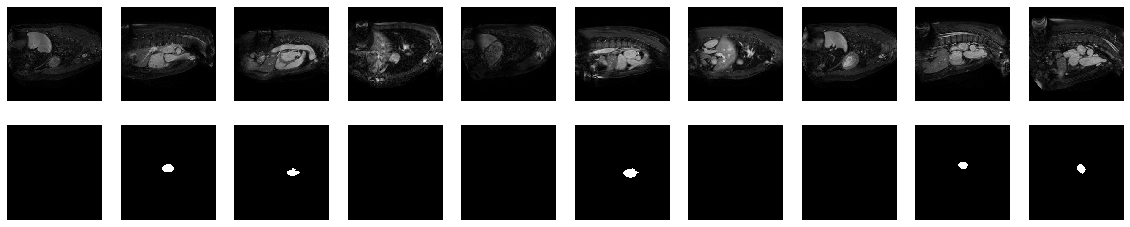

Epoch #24
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 82s 54ms/step - loss: 7.7627e-04 - val_loss: 8.5477e-04


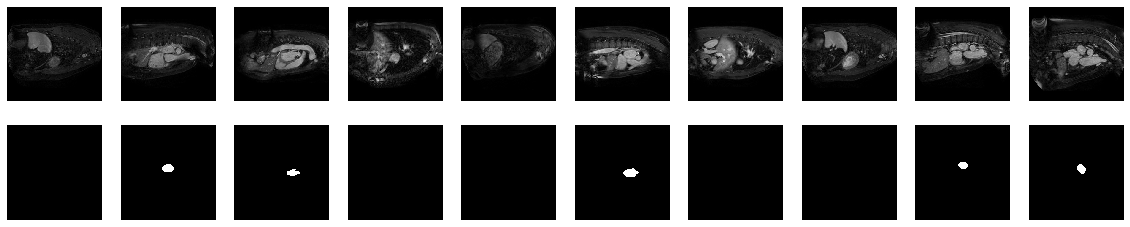

Epoch #25
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 54ms/step - loss: 7.1034e-04 - val_loss: 8.9602e-04


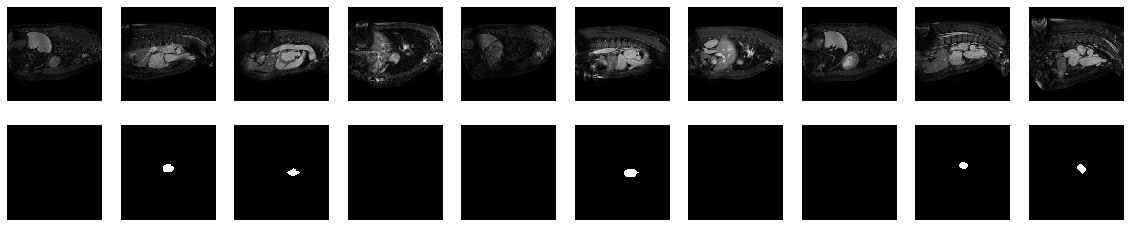

Epoch #26
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 82s 54ms/step - loss: 6.3177e-04 - val_loss: 7.3002e-04


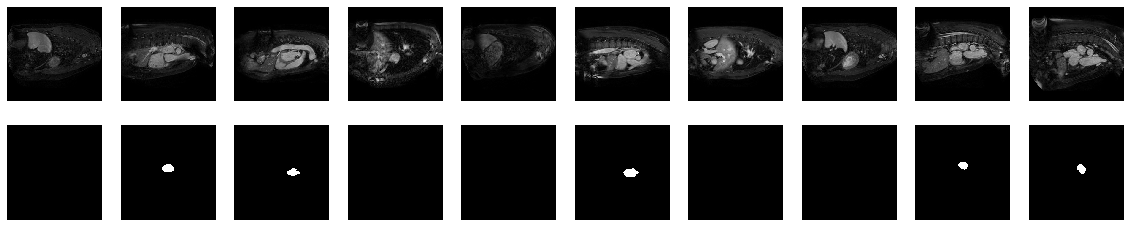

Epoch #27
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 54ms/step - loss: 5.8888e-04 - val_loss: 6.6150e-04


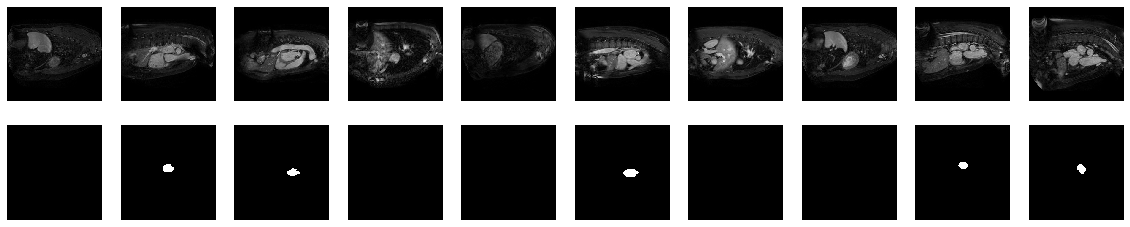

Epoch #28
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 54ms/step - loss: 5.4397e-04 - val_loss: 6.6991e-04


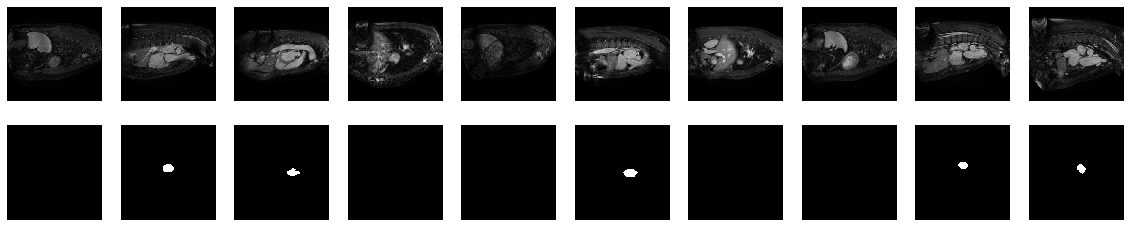

Epoch #29
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 81s 54ms/step - loss: 5.0602e-04 - val_loss: 5.8370e-04


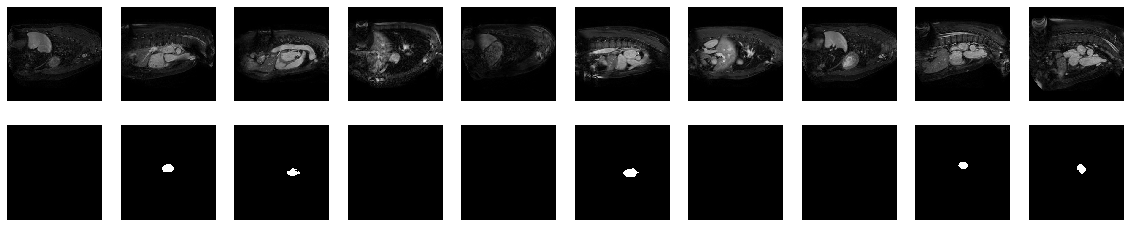

Epoch #30
Train on 1512 samples, validate on 300 samples
Epoch 1/1
1512/1512 [==============================] - 82s 54ms/step - loss: 4.6816e-04 - val_loss: 5.8389e-04


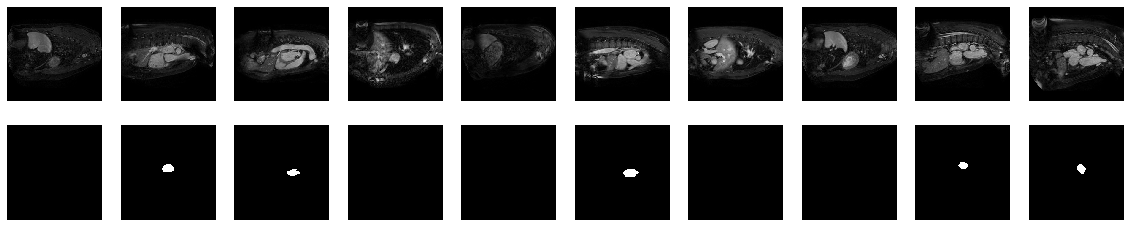

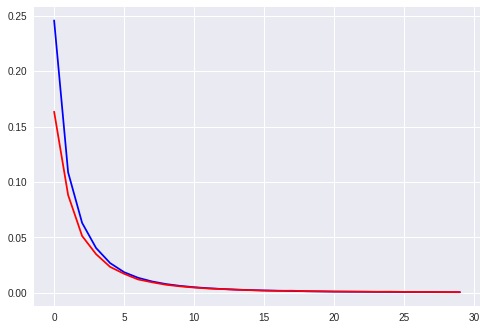

In [7]:
model.compile(optimizer=Adam(1e-4), loss=dice_loss)
n_epochs = 30
train_loss = []
val_loss = []
for i in range(n_epochs):
  print('Epoch #%d' % (i+1))
  hist = model.fit(X_tr, Y_tr, validation_data=(X_va, Y_va), batch_size=12, epochs=1, verbose=1, shuffle=True)
  display(model, X_tr, 10)
  train_loss.append(hist.history['loss'])
  val_loss.append(hist.history['val_loss'])
  
fig, loss_ax = plt.subplots()
loss_ax.plot(train_loss, 'b', label='training loss')
loss_ax.plot(val_loss, 'r', label='val loss')
plt.show()

## **6. Test and Evaluation**

In [8]:

def dice_eval(net, X, Y):
  
  Y_hat = net.predict(X)
  Y_map = np.argmax(Y_hat, axis=3)
  ans = np.argmax(Y, axis=3)
  
  DICE = 2*np.sum(ans * Y_map) / (np.sum(ans) + np.sum(Y_map))
  
  return DICE

DICE_tr = dice_eval(model, X_tr, Y_tr)
DICE_va = dice_eval(model, X_va, Y_va)
DICE_ts = dice_eval(model, X_ts, Y_ts)

print('DICE coefficient for training dataset: %.2f %%' % (DICE_tr*100))
print('DICE coefficient for validation dataset: %.2f %%' % (DICE_va*100))
print('DICE coefficient for test dataset: %.2f %%' % (DICE_ts*100))

DICE coefficient for training dataset: 97.28 %
DICE coefficient for validation dataset: 96.29 %
DICE coefficient for test dataset: 90.04 %


## **7. Saving model**

In [9]:
!mkdir data/Heart/model
!ls data/Heart/model

mkdir: cannot create directory ‘data/Heart/model’: File exists
model  Unet_Diceloss1.h5  Unet_Diceloss1.json


In [10]:
import h5py
model_json = model.to_json()
with open('data/Heart/model/Unet_Diceloss2.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('data/Heart/model/Unet_Diceloss2.h5')
print('Saved model to disk')

Saved model to disk


In [0]:
!cp -r data/Heart/model /content/gdrive/'My Drive'/'Colab Notebooks'/'Heart'

<function matplotlib.pyplot.show>

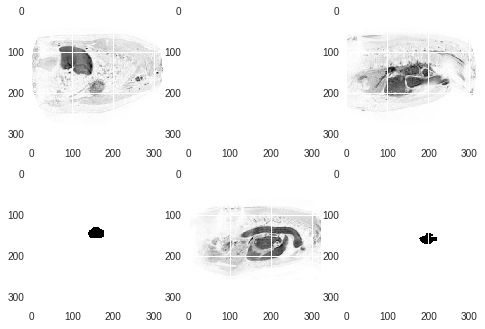

In [12]:
plt.figure()
plt.subplot(2,3,1)
plt.imshow(np.squeeze(X_tr[100,]))
plt.subplot(2,3,2)
plt.imshow(np.argmax(Y_tr[100,], axis=2))
plt.subplot(2,3,3)
plt.imshow(np.squeeze(X_tr[200,]))
plt.subplot(2,3,4)
plt.imshow(np.argmax(Y_tr[200,], axis=2))
plt.subplot(2,3,5)
plt.imshow(np.squeeze(X_tr[300,]))
plt.subplot(2,3,6)
plt.imshow(np.argmax(Y_tr[300,], axis=2))
plt.show